# Lib

In [105]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

from torchvision.datasets import MNIST

In [106]:
#os.chdir("/content/drive/MyDrive/AD Last Research")

# Helper Functions

In [107]:
from sklearn.manifold import TSNE

def get_2d_tsne(x):
    tsne = TSNE(n_components=2, random_state=0,  learning_rate='auto', init='random')
    x_2d = tsne.fit_transform(x)

    return x_2d

In [108]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [109]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 128, 128)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [110]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

# Gen

In [111]:
from mymodels.generator import Generator_XL, Generator_S

In [112]:
generator = Generator_S(features=64,
                        img_size=32,
                        latent_dim=100,
                        channels=3)
count_parameters(generator)

1051139

# Disc

In [113]:
from mymodels.discriminator import Discriminator

In [114]:
discriminator = Discriminator(features=32, channels=3, img_size=32, optimization='gan')

In [115]:
count_parameters(discriminator)

390337

# Data

In [116]:
from dataset import customdataset
from dataset.customdataset import get_dataset_2_classes
from torch.utils.data import ConcatDataset

In [117]:
img_size = 32
channels = 1
batch_size = 10
normal_label = 8
ano_label = 1
num_data = 1000

In [118]:
# Datasets
train_normal_ds, train_ano_ds = get_dataset_2_classes(dataset_name='mnist', train=True,
                                                      normal_label=normal_label, ano_label=ano_label,
                                                      img_size=img_size, channels=channels,
                                                      data_path="./MNIST", download=True)

test_normal_ds, test_ano_ds = get_dataset_2_classes(dataset_name='mnist', train=False,
                                                      normal_label=normal_label, ano_label=ano_label,
                                                      img_size=img_size, channels=channels,
                                                      data_path="./MNIST", download=True)

In [119]:
# Dataloader for GAN
train_normal_loader = DataLoader(train_normal_ds, batch_size=batch_size,
                                 sampler=SubsetRandomSampler(list(range(num_data))))

In [120]:
# Dataloader for VIT
train_ds = ConcatDataset([train_normal_ds, train_ano_ds])
train_indx = SubsetRandomSampler(list(np.floor(np.random.uniform(0, len(train_ds), num_data)).astype(int)))
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=train_indx)

# Vanilla GAN

### Hyperparameters

In [121]:
device = 'cuda'
latent_dim = 100

### All in One

In [122]:
# Nets
generator = Generator_S(features=64,
                        img_size=img_size,
                        latent_dim=latent_dim,
                        channels=channels).to(device)

discriminator = Discriminator(features=16, channels=channels, img_size=img_size, optimization='gan', last_bias = False).to(device)

In [123]:
# Loss & Optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters())
optimizer_D = optim.Adam(discriminator.parameters())

### Re-Init

In [124]:
# WRONG

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [125]:
generator = generator.apply(weights_init_normal)
discriminator = discriminator.apply(weights_init_normal)

### Train

In [126]:
#save_tsne = {}
total_G_loss = 0.0
total_D_loss = 0.0

In [127]:
device = 'cuda'

init_epoch = 1
num_epochs = 1000
sample_interval = 20

In [100]:
"""
root_bp = "./results/vanilla_gan_research/last_parameters.pt"

info = torch.load(root_bp)
init_epoch = info['epoch']
generator.load_state_dict(info['state_dict_G'])
discriminator.load_state_dict(info['state_dict_D'])
optimizer_G.load_state_dict(info['optimizer_G'])
optimizer_D.load_state_dict(info['optimizer_D'])
save_tsne = info['save_tsne']
"""

'\nroot_bp = "./results/vanilla_gan_research/last_parameters.pt"\n\ninfo = torch.load(root_bp)\ninit_epoch = info[\'epoch\']\ngenerator.load_state_dict(info[\'state_dict_G\'])\ndiscriminator.load_state_dict(info[\'state_dict_D\'])\noptimizer_G.load_state_dict(info[\'optimizer_G\'])\noptimizer_D.load_state_dict(info[\'optimizer_D\'])\nsave_tsne = info[\'save_tsne\']\n'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


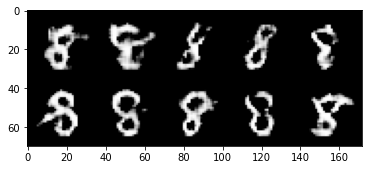

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


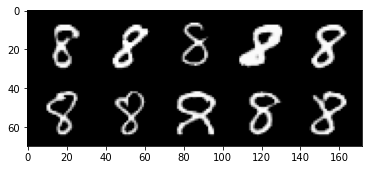

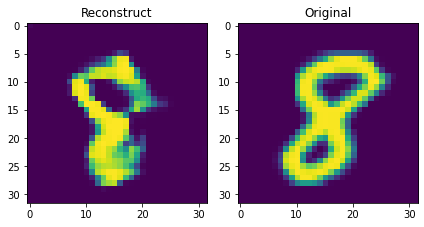

KeyboardInterrupt: 

In [101]:
torch.cuda.empty_cache()
for epoch in range(init_epoch, num_epochs+1):
    torch.cuda.empty_cache()
    # Load Train Data ##############################################
    for i, (real_images, _) in enumerate(train_normal_loader):
        torch.cuda.empty_cache()
        # Preprocessing ##############################################
        valid = torch.FloatTensor(real_images.shape[0], 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(real_images.shape[0], 1).fill_(0.0).to(device)
        real_images = real_images.to(device)
        generator = generator.to(device)
        discriminator = discriminator.to(device)

        # Train Generator ########################################
        optimizer_G.zero_grad()
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)

        g_loss_adv = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss = g_loss_adv
        g_loss.backward()
        optimizer_G.step()
        total_G_loss += g_loss.cpu().detach().numpy()


        # Train Discriminator ########################################
        optimizer_D.zero_grad()
        discriminator_opinion_real = discriminator(real_images)
        discriminator_opinion_fake = discriminator(gen_imgs.detach())
        real_loss = adversarial_loss(discriminator_opinion_real, valid)
        fake_loss = adversarial_loss(discriminator_opinion_fake, fake)
        d_loss_adv = (real_loss + fake_loss) / 2
        d_loss = d_loss_adv

        d_loss.backward()
        optimizer_D.step()
        total_D_loss += d_loss.cpu().detach().numpy()


    # Load Test Data ##############################################
    torch.cuda.empty_cache()
    if epoch%sample_interval==0 or epoch==1:
      # Visualization ##############################################
      show_tensor_images(gen_imgs, size=(channels, img_size, img_size))
      show_tensor_images(real_images, size=(channels, img_size, img_size))

      num = math.floor(np.random.uniform(0, len(real_images)))
      ploter(real_images.detach().cpu()[num][0], gen_imgs.detach().cpu()[num][0])


      torch.save({"epoch": epoch,
      "state_dict_G": generator.state_dict(),
      "state_dict_D": discriminator.state_dict(),
      "optimizer_G": optimizer_G.state_dict(),
      "optimizer_D": optimizer_D.state_dict(),
      }, f"./save_pts/vanillagan_epoch_{epoch}.pt")

# ViT Model

### Load best model

In [129]:
# Nets
generator = Generator_S(features=64,
                        img_size=img_size,
                        latent_dim=latent_dim,
                        channels=channels).to(device)

discriminator = Discriminator(features=16, channels=channels, img_size=img_size, optimization='gan', last_bias = False).to(device)

In [130]:
epoch = 1
root_bp = f"./save_pts/vanillagan_epoch_{epoch}.pt"

info = torch.load(root_bp)
init_epoch = info['epoch']
generator.load_state_dict(info['state_dict_G'])
discriminator.load_state_dict(info['state_dict_D'])

<All keys matched successfully>

In [ ]:
z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
gen_imgs = generator(z)

# Visualization ##############################################
show_tensor_images(gen_imgs, size=(channels, img_size, img_size))
show_tensor_images(real_images, size=(channels, img_size, img_size))

num = math.floor(np.random.uniform(0, len(real_images)))
ploter(real_images.detach().cpu()[num][0], gen_imgs.detach().cpu()[num][0])

### Outputs

### Dataset

In [88]:
from dataset import customdataset
from dataset.customdataset import get_dataset_2_classes
from torch.utils.data import ConcatDataset

In [89]:
img_size = 32
channels = 1
batch_size = 16
normal_label = 8
ano_label = 1
num_data = 1000

In [90]:
# Datasets
train_normal_ds, train_ano_ds = get_dataset_2_classes(dataset_name='mnist', train=True,
                                                      normal_label=normal_label, ano_label=ano_label,
                                                      img_size=img_size, channels=channels,
                                                      data_path="./MNIST", download=True)

test_normal_ds, test_ano_ds = get_dataset_2_classes(dataset_name='mnist', train=False,
                                                      normal_label=normal_label, ano_label=ano_label,
                                                      img_size=img_size, channels=channels,
                                                      data_path="./MNIST", download=True)

In [ ]:
z = torch.FloatTensor(np.random.normal(0, 1, (train_normal_ds.__len__(), latent_dim))).to(device)
gen_imgs = generator(z)
train_ds = customdataset.get_train_dataset_classify(normal_train_ds=train_normal_ds, gen_imgs=gen_imgs,
                                                    img_size, channels)

train_indx = SubsetRandomSampler(list(np.floor(np.random.uniform(0, len(train_ds), num_data)).astype(int)))
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=train_indx)

In [92]:
# Dataloader for VIT
train_ds = ConcatDataset([train_normal_ds, train_ano_ds])
train_indx = SubsetRandomSampler(list(np.floor(np.random.uniform(0, len(train_ds), num_data)).astype(int)))
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=train_indx)

### Model

In [ ]:
!pip install wget
import wget
filename = wget.download("https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz")

In [104]:
from models.modeling import VisionTransformer
import tqdm

In [ ]:
model = VisionTransformer('ViT-B_16', img_size, num_classes=2, zero_head=True)
model.load_from(np.load(filename))
model = model.to(device)

### Train

In [102]:
def freeze_model(model, layers=6):
    for i in range(layers):
        for p in model.transformer.encoder.layer[i].parameters():
            p.requires_grad = False

In [ ]:
lr = 4e-4
weight_decay = 5e-5
num_epochs = 30

In [ ]:
freeze_model(model)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
model.train()
loss_funct = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs+1):
    total_num, total_loss = 0, 0
    train_bar = tqdm(train_loader)
    for (x, y) in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = loss_funct(logits, y)
        loss.backward()
        optimizer.step()
        total_num += x.size(0)
        total_loss += loss.item() * x.size(0)
        train_bar.set_description(f'Training Epoch : {epoch}, Loss: {total_loss / total_num:.6f}')
    print("=" * 100)